<a href="https://colab.research.google.com/github/patrick-hanley/thought_experiments/blob/master/2021-02-05-fastai_crunchbase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Helping VCs target the next acquisition with better than 90% confidence

#    After analyzing start-up funding data from over 49,000 startups, I can predict which companies are going to be aquired and which are going to be defunct.


This [dataset](https://www.kaggle.com/arindam235/startup-investments-crunchbase) originated from Crunchbase and was downloaded from kaggle.



In [1]:
#hide

%reload_ext autoreload
%autoreload 2
%matplotlib inline

!pip install fastai --upgrade --q

from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
#import matplotlib.style as style
#style.use('fivethirtyeight')

from IPython.display import Image, display_svg, SVG
from sklearn.model_selection import train_test_split

from google.colab import drive
mnt=drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"


Mounted at /content/gdrive


# **Overall Strategy**

##Using the Fast.AI library, I used shallow neural networks to encode all the categorical features of the funding data (company market space, city, region, amount per round) and then extracted the embedding layers for further analysis with Machine Learning models.



## Instead of a simple label encoding of each feature, I created different vector representations of multiple lengths for each network.
  The sample below shows a vector of length 3.  
The advantage is that we are able to transform discreet variables into vectors that are continous and meaningful.
> > ### <img alt="Label Embeddings vs Vector Embedding" width="800" caption="Label Embeddings vs Vector Embedding (derived from latent space of neural network)" id="city_emb" src="https://drive.google.com/uc?id=1zszZ7eTR0Fe0QVhDto_YTrPop_XoyvDB">

---








In the Fast.AI book, [Deep Learning for Coders](https://www.amazon.com/Deep-Learning-Coders-fastai-PyTorch/dp/1492045527), an excellent example of the benefits of categorical embedding is provided.

> On the left is a plot of the embedding matrix for the possible values of the State category. For a categorical variable we call the possible values of the variable its "levels" (or "categories" or "classes"), so here one level is "Berlin," another is "Hamburg," etc. On the right is a map of Germany. The actual physical locations of the German states were not part of the provided data, yet the model itself learned where they must be, based only on the behavior of store sales!


### <img alt="State embeddings and map" width="800" caption="State embeddings and map (courtesy of Cheng Guo and Felix Berkhahn)" id="state_emb" src="https://drive.google.com/uc?id=1Vzc203MEmeGa3X3m7MM199xRSMpfbXyV">



# Ensembling the embeddings 
What makes this code unique is the fact that I took the same data and ran it through 4 different shallow neural networks with a unique embedding size.

For each neural net, I extracted the latent layers and trained a Random Forest model on each embedding space and then ensembled the predictions and probabilites. The end result was an improvement of > 6%.  

The predictions improve because each model puts an emphasis on different features of the input data.

The two charts shown below show the top 10 features based on the importance to the model.  Each model analyzes the data differently based on the relative importance of the features.  Remember, the underlying data is identical, but I'm analyzing the latent space with different embedding sizes.

For example, the Random Forest model training on a fixed embedding size of 2, ranks a member of the 'City' vector(City_0) as the most important feature.  Where as the Random Forest using the default embeddings, ranks City_0 8th from the top.


<!-- ### <img alt="State embeddings and map" width="1200" caption="feature importance of different embedding sizes" id="fi_emb" src="https://drive.google.com/uc?id=1bf2h4DOXLvLChoPCcPSFDh8M87a7nyDF"> -->

<p float="left">
  <img src="https://drive.google.com/uc?id=1-Amuz7zrJL-yO9t7Ip8Tamt8URG5Sntu"/>
  <img src="https://drive.google.com/uc?id=1-hUkVHPhoX-jWVLwhffIR2cYhB22cvms"/> 
</p>













# The overall strategy to predict the acquisition of the startup was the following:


1.   Import and clean the data
2.   Create additional features
3.   Run data through multiple shallow neural networks to convert categorical data to continous
4.   Train ML models on the latent space of the neural nets
5.   Ensemble the predictions from each model
6.   Train ML model on the Ensemble
7.   Select the most confident prediction





In [46]:
#hide
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

def feat_importance(m, df):
  # get list of feature importance for given model
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                      ).sort_values('imp', ascending=False)

    
def save_predictions(model_name, m, df, target_names, note):
  col = []
  for target_name in target_names:
    tmp = "_".join([model_name, target_name, note])
    col.append(tmp)
  try:
    predictions = m.predict_log_proba(df)
  except:
    predictions = m.predict_proba(df)
  
  predict_df = pd.DataFrame(predictions, columns=col).astype("float")
  delta_name = "_".join(['delta', col[1], col[0]])
  predict_df[delta_name] = predict_df[col[1]] - predict_df[col[0]]
  #predict_df['company_index']=df.index
  return predict_df

# modified based on this blog: https://towardsdatascience.com/quickly-test-multiple-models-a98477476f0
def run_exps(models, X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame, note, seed=90210) -> pd.DataFrame:
    '''
    Lightweight script to test many models and find winners
    :param models: array of tuples containing (model_name, model)
    :param X_train: training split
    :param y_train: training target vector
    :param X_test: test split
    :param y_test: test target vector
    :note: 
    :seed: int for randomizer
    :return: DataFrame of predictions
    '''
    #print ( embeded_xs_1.shape, y_train.shape, xs_valid_1.shape, y_test.shape)
    dfs = []
    dfs_predictions = []

    results = []
    names = []
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
    target_names = ['closed', 'aquired']
    for model_name, model in models:
        kfold = model_selection.KFold(n_splits=5, shuffle=True,
                                      random_state=seed)
        
        cv_results = model_selection.cross_validate(model, X_train, y_train,
                                                    cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print((model_name, note))
        print(classification_report(y_test, y_pred, target_names=target_names))
        #try:
        fi=feat_importance(clf, X_test)
        plot_fi(model_name, note, fi[:10])
        # except:
        #   print('fail to plot')
        print ()
        predict_df=save_predictions(model_name, clf, X_test, target_names, note)
        names.append(model_name)

        dfs_predictions.append(predict_df)
    prediction_dfs = pd.concat(dfs_predictions, axis=1)
    return prediction_dfs 

def nn_embeddings(emb_szs=None):
  # use a neural network to create ebeddings of categorical data
  #random_seed(seed, use_cuda=False )
  learn = tabular_learner(dls,layers=[200,100], metrics=accuracy,
                          emb_szs=emb_szs)

  #random_seed(seed,use_cuda=False )
  lr_in, lr_steep = learn.lr_find(show_plot=True)
  #random_seed(seed, use_cuda=False )
  learn.fit_one_cycle(20, lr_steep, cbs=EarlyStoppingCallback( 
      monitor='accuracy', min_delta=0.001, patience=2))
  
  # after fitting, get embeddings to be used by ML
  embeded_xs = embed_features(learn, learn.dls.train.xs)
  xs_valid = embed_features(learn, learn.dls.valid.xs)

  return (learn, embeded_xs, xs_valid)

def embed_features(learner, xs):
  # https://forums.fast.ai/t/using-embedding-from-the-neural-network-in-random-forests/80063/9
  # citation: danielwbn
    xs = xs.copy()
    for i, feature in enumerate(learner.dls.cat_names):
        emb = learner.model.embeds[i]
        new_feat = pd.DataFrame(emb(tensor(xs[feature], dtype=torch.int64)), index=xs.index, columns=[f'{feature}_{j}' for j in range(emb.embedding_dim)])
        xs.drop(columns=feature, inplace=True)
        xs = xs.join(new_feat)
    return xs

def plot_fi(name, note, fi):

    title = "_".join([name, note])
    fi_plot = fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
    
    fi_plot.tick_params(axis = 'both', which = 'major', labelsize = 18)

    # Remove the label of the x-axis
    fi_plot.xaxis.label.set_visible(False)
     # Remove the label of the y-axis
    fi_plot.yaxis.label.set_visible(False)
    titles="        " + title
    fi_plot.text(x = .0, y = 10, s = titles,
               fontsize = 26, weight = 'bold', alpha = .75)
    
    fig=fi_plot.get_figure()
    img_path = Path(base_dir + '/' + title + '.png')
    fig.savefig(img_path, bbox_inches = 'tight')

    return fi_plot



In [47]:
# hide
# @title
# https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
# George Fisher
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# Import the data, split into Training and Test, Split into continous and categorical data


In [48]:
#hide
# load pre-processed data
base_dir = root_dir + 'crunchbase'
path = Path(base_dir)
csv_path = Path(base_dir+'/crunchbase_data_cleaned_3.csv')
df = pd.read_csv(csv_path)
print(csv_path)

cleanup_nums = {"status":     {2: True, 1:False}}
df = df.replace(cleanup_nums)
company_names = df.name # For use later, but not necessary to use it for learning
#city_names=df.city
y=df.status
X=df.copy()
X.drop(['status','name'],axis=1,inplace=True)

dep_var = 'status'



test_size = 0.2
seed=7
#random_seed(seed,use_cuda=False )
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
splits = (list(X_train.index),list(X_test.index))

df.drop('name', axis=1, inplace=True)
cont_nn, cat_nn = cont_cat_split(df, max_card=10, dep_var=dep_var)

/content/gdrive/My Drive/crunchbase/crunchbase_data_cleaned_3.csv


In [50]:
# #hide
# #to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)
# print(csv_path)
# df = pd.read_csv(csv_path)
# cleanup_nums = {"status":     {2: True, 1:False}}
# df = df.replace(cleanup_nums)
# company_names = df.name # For use later, but not necessary to use it for learning
# city_names=df.city
# y=df.status
# X=df.copy()
# X.drop(['status','name'],axis=1,inplace=True)


# # use reduced columns indicated by feature importance
# use_reduced = False
# dep_var = 'status'

# def use_reduced_features(use_reduced):
#   if use_reduced:  
#     return (df[list(xs_imp.columns) + [dep_var]])

#   return df[list(X.columns) + [dep_var]]


# df_nn_final = use_reduced_features (use_reduced)

# y=df_nn_final.status
# X=df_nn_final.copy()
# X.drop(['status'],axis=1,inplace=True)


# seed = 7
# test_size = 0.2
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
# splits = (list(X_train.index),list(X_test.index))


# df_nn_final = df_nn_final.astype({'funding_total_usd': 'int64',
#                                   'first_funding_year':'int64',
#                                   'founded_year':'int64',
#                                   'last_funding_year':'int64',
#                                   'funding_rounds':'int64',
#                                   'venture': 'int64'})

# cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=10, dep_var=dep_var)
# df=df_nn_final.copy()

# Run data through multiple shallow neural networks to convert categorical to continous dat


epoch,train_loss,valid_loss,accuracy,time
0,0.655318,0.642447,0.652299,00:00
1,0.626727,0.638250,0.650862,00:00
2,0.606088,0.640431,0.673851,00:00
3,0.580404,0.673941,0.659483,00:00
4,0.559606,0.694179,0.669540,00:00


No improvement since epoch 2: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.667185,0.662984,0.636494,00:00
1,0.640012,0.645128,0.658046,00:00
2,0.607496,0.633583,0.659483,00:00
3,0.575841,0.629245,0.669540,00:00
4,0.545199,0.635993,0.672414,00:00
5,0.517135,0.637185,0.670977,00:00
6,0.489748,0.700667,0.632184,00:00


No improvement since epoch 4: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.701476,0.665893,0.646552,00:00
1,0.658531,0.634207,0.650862,00:00
2,0.620302,0.608778,0.668103,00:00
3,0.583453,0.627034,0.683908,00:00
4,0.549899,0.628326,0.693965,00:00
5,0.517049,0.662097,0.699713,00:00
6,0.490719,0.693638,0.669540,00:00
7,0.465258,0.706148,0.662356,00:00


No improvement since epoch 5: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,0.687618,0.683836,0.556035,00:00
1,0.639597,0.665484,0.635057,00:00
2,0.592642,0.643868,0.647988,00:00
3,0.540260,0.634367,0.636494,00:00
4,0.492084,0.635531,0.656609,00:00
5,0.444703,0.652318,0.650862,00:00
6,0.401381,0.724165,0.617816,00:00


No improvement since epoch 4: early stopping


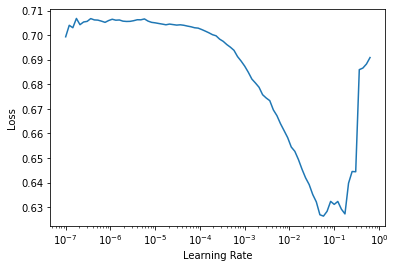

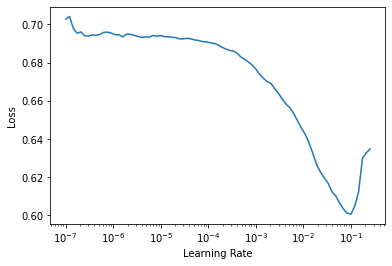

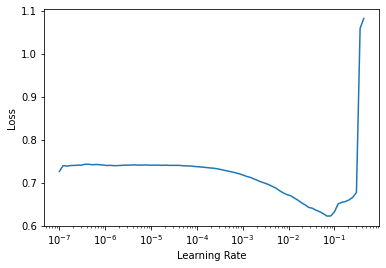

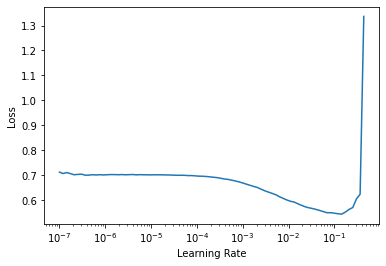

In [51]:
models = [
      #('rf', RandomForestClassifier()),
      ('RandomForest', RandomForestClassifier(max_depth=200,
                                              random_state=seed,
                                              oob_score=True,
                                              min_samples_split=30)),
      #('xgb', XGBClassifier()),    
    ]

#prepare data for neural net
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)
dls = to_nn.dataloaders(512)

# override default embeddings

# ebedding set to 1
emb_szs={'city':1, 'market':1,'region':1,'founded_month':1, 
         'founded_quarter':1,'state_code':1}
_, embeded_xs_1, xs_valid_1 = nn_embeddings(emb_szs)
# embed_1_df = run_exps(models, embeded_xs_1, y_train, xs_valid_1, y_test,
#                       'embed_1',)


# ebedding set to 2
emb_szs={'city':2, 'market':2,'region':2,'founded_month':2, 
         'founded_quarter':2,'state_code':2}
_, embeded_xs_2, xs_valid_2 = nn_embeddings(emb_szs)
# embed_2_df = run_exps(models, embeded_xs_2, y_train, xs_valid_2, y_test,
#                       'embed_2')



# ebedding set to 3
emb_szs={'city':3, 'market':3,'region':3,'founded_month':3, 
         'founded_quarter':3,'state_code':3}
_, embeded_xs_3, xs_valid_3 = nn_embeddings(emb_szs)
# embed_3_df = run_exps(models, embeded_xs_3, y_train, xs_valid_3, y_test,
#                       'embed_3')



# default embedding based on cardinality of data
_, embeded_xs_default, xs_valid_default = nn_embeddings(None)
# embed_default_df = run_exps(models, embeded_xs_default, y_train,
#                             xs_valid_default, y_test, 'default_embedding')



# Train ML models on the latent space of the neural nets

('RandomForest', 'embed_1')
              precision    recall  f1-score   support

      closed       0.68      0.60      0.64       308
     aquired       0.71      0.77      0.74       388

    accuracy                           0.70       696
   macro avg       0.69      0.69      0.69       696
weighted avg       0.70      0.70      0.69       696


('RandomForest', 'embed_2')
              precision    recall  f1-score   support

      closed       0.66      0.58      0.62       308
     aquired       0.70      0.76      0.73       388

    accuracy                           0.68       696
   macro avg       0.68      0.67      0.67       696
weighted avg       0.68      0.68      0.68       696


('RandomForest', 'embed_3')
              precision    recall  f1-score   support

      closed       0.66      0.57      0.61       308
     aquired       0.69      0.76      0.72       388

    accuracy                           0.68       696
   macro avg       0.67      0.67      0.6

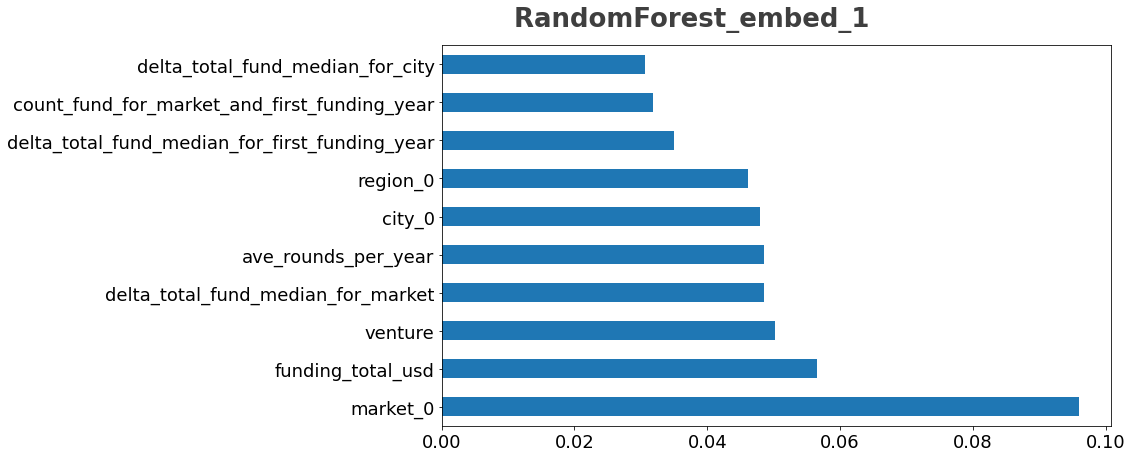

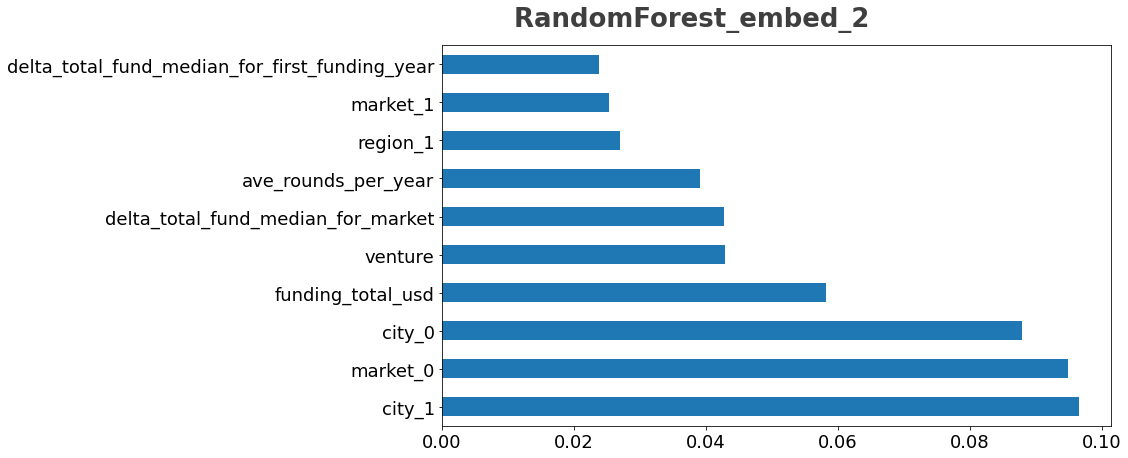

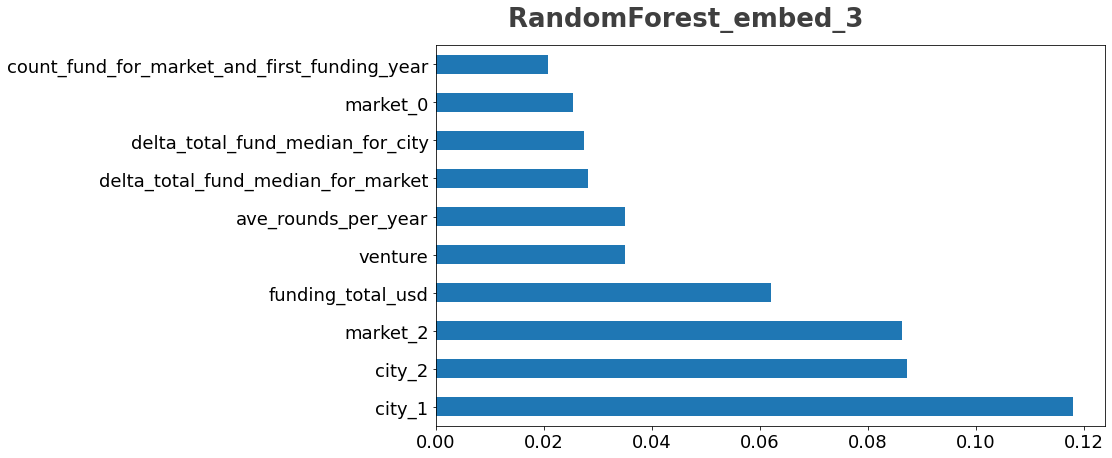

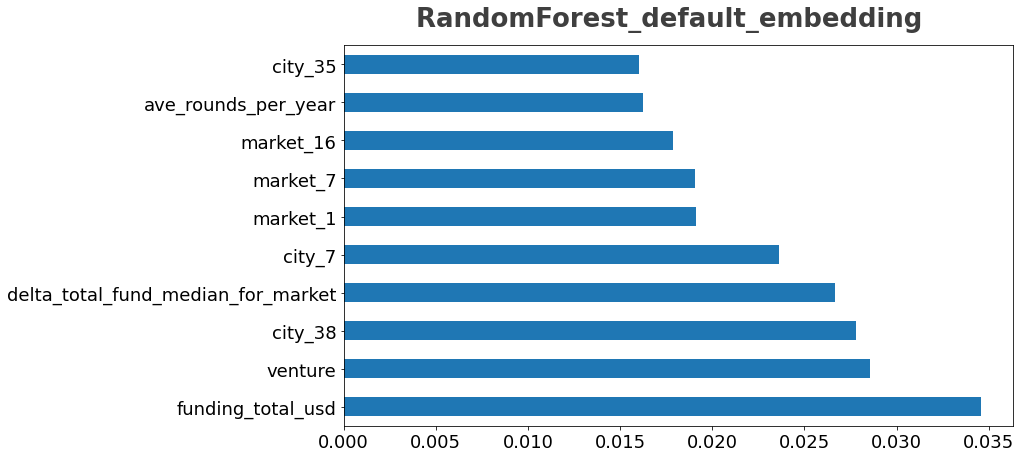

In [52]:
# array of ML models (only using one for demonstration)

models = [
      #('rf', RandomForestClassifier()),
      ('RandomForest', RandomForestClassifier(max_depth=200,
                                              random_state=seed,
                                              oob_score=True,
                                              min_samples_split=30)),
      #('xgb', XGBClassifier()),    
    ]

embed_1_df = run_exps(models, embeded_xs_1, y_train, xs_valid_1, y_test,
                      'embed_1',)

embed_2_df = run_exps(models, embeded_xs_2, y_train, xs_valid_2, y_test,
                      'embed_2')

embed_3_df = run_exps(models, embeded_xs_3, y_train, xs_valid_3, y_test,
                      'embed_3')

embed_default_df = run_exps(models, embeded_xs_default, y_train,
                            xs_valid_default, y_test, 'default_embedding')

# Ensemble the predictions from each model

In [53]:
#show
#combine all predictions into single dataframe and train with RF

#del combined_predictions
combined_predictions = pd.concat([embed_1_df, embed_2_df, embed_3_df, embed_default_df ], axis=1)
combined_predictions = combined_predictions.T.drop_duplicates().T

#just dropped
#combined_predictions.set_index('company_index', inplace=True)
combined_predictions.drop(['company_index'],axis=1,inplace=True, errors='ignore')
combined_predictions.drop(['combined_confidence'],axis=1,inplace=True, errors='ignore')

#seed=4 #73.5 90%
#seed=5 #71. 91%
#seed=6
#now need to split d2 into train and valid sets
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(combined_predictions, y_test, test_size=test_size, random_state=seed)

#Train ML model on the Ensemble

In [54]:
#show
#clf = RandomForestClassifier()
clf = RandomForestClassifier(max_depth=200, random_state=seed, oob_score=True, min_samples_split=30)
clf.fit(X_train_combined, y_train_combined)
print (clf.score(X_test_combined, y_test_combined))

0.7714285714285715


## The ensemble of the latent layers improves the model by > 6%.  To reach 95% accuracy, I focus on the top 20% of the companies based on the confidence of the model.




#Select the most confident prediction

In [55]:
#show
predicted_val=clf.predict_proba(X_test_combined)
predicted=clf.predict(X_test_combined)

pred_df=pd.DataFrame(predicted_val, columns=['z','o'])
#pred_df['names']=(X_test_combined.company_index.values)

pred_df['target']=y_test_combined.values
pred_df['names']=y_test_combined.index
pred_df['predict_acquisition']=predicted


pred_df['diff'] = pred_df.apply(lambda x: x['o'] - x['z'], axis=1)
confident_pred_df=pred_df[(pred_df['diff']>.7) | (pred_df['diff']<-.65)]

confident_pred_df.set_index('names',inplace=True)

final_acquisition_predictions = pd.merge(company_names, confident_pred_df,
                                         how = 'right',left_index = True,
                                         right_index = True)

final_acquisition_predictions.drop(['o','z'], inplace=True, axis=1, 
                                  )

final_acquisition_predictions.index.name = 'idx_name'
final_acquisition_predictions.sort_values(by='diff')

,name,target,predict_acquisition,diff
idx_name,,,,
1228,Ground Zero Group Corporation,False,False,-0.932718
1851,MobAppCreator,False,False,-0.888299
3359,WHObyYOU,False,False,-0.864687
1936,MyDatingTree,False,False,-0.857404
2760,Social GameWorks,False,False,-0.853628
3427,Your Survival,False,False,-0.850610
1151,Gifts that Give,False,False,-0.821114
1032,FirePower Technology,False,False,-0.817946
524,Cerelink,False,False,-0.808390


# Interesting high confidence predictions
I predicted that Kickfire was aquired with a 79% confidence, however the data provided by Crunchbase listed it as a closed.  After investigation, Kickfire was actually aquired in 2010 by [Teradata](https://www.teradata.com/).  Details can be found in this [article](https://https://www.infoworld.com/article/2625533/teradata-buys-analytics-vendor-kickfire.html).

Similarly, I predicted Color Labs Inc. was aquired, but the data provided said it closed.  Apple aquired Color Labs Inc. for $7M in 2012.


The other company that I predicted would get aquired is Breaktime Studios.  This company went under in 2016.

While I was able to make accurate predictions on the limited data of market type and the aount of funding in each round.  It would have been helpful to know who was making the investments.  Was it credible VCs with a known trackrecord or individuals.  Stay tuined while I add this to the model.




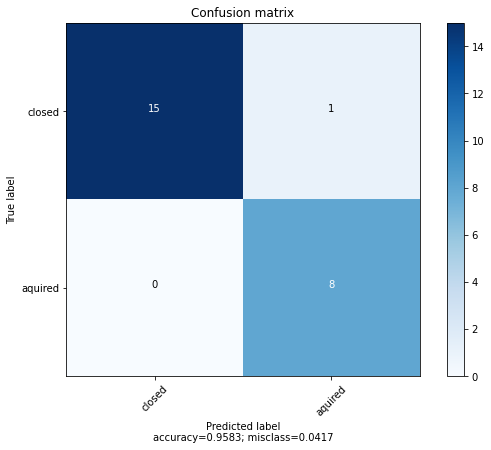

In [56]:
#collapse-show
cm=confusion_matrix(final_acquisition_predictions.target, final_acquisition_predictions.predict_acquisition,  labels=None, sample_weight=None, normalize=None)
plot_confusion_matrix(cm, ['closed','aquired'], normalize=None)